# Part A: IMDb Movie Review Sentiment Analysis

## Video Presentation: [Click here](https://drive.google.com/file/d/1_Yztv1Q1yPcr7Qz_1SsepJ4hnrbm4fOY/view?usp=drive_link)

In [647]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import uniform

In [175]:
# Download necessary NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\abelj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abelj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abelj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
imdb_data = pd.read_csv("data_imdb.csv")
imdb_data.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


## 1. Data Exploration and Preprocessing

### Analyze the dataset for trends, missing values, and outliers

#### a. Missing values

In [12]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


- There are 50,000 rows and no missing values.

#### b. Unique reviews

In [9]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49581,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


- 419 reviews are not unique and need to be removed.

#### c. Sentiment distribution

In [20]:
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

- The sentiment classes are balanced with each having 25,000 records.

#### d. Review length outliers

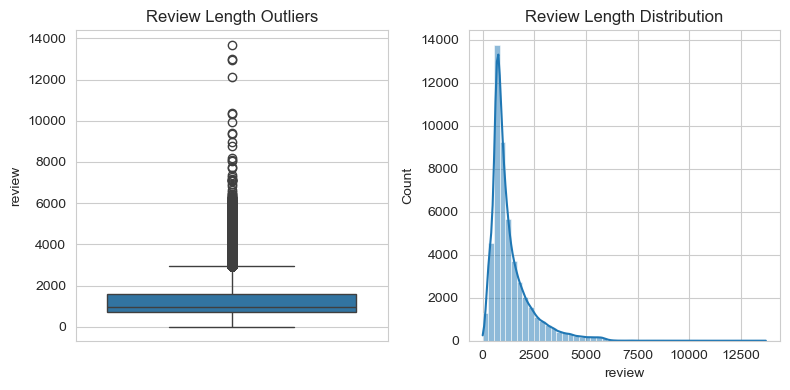

In [132]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(imdb_data['review'].apply(len), ax=axes[0])
axes[0].set_title("Review Length Outliers")

sns.histplot(imdb_data['review'].apply(len), bins=50, kde=True, ax=axes[1])
axes[1].set_title("Review Length Distribution")

plt.tight_layout()
plt.show()

- There are so many outliers too far away from the upper limit.
- The review length is positively skewed.

- The review length is positively skewed.

### Perform data cleaning and text preprocessing

#### a. Keep only unique reviews

In [58]:
imdb_data_unique = imdb_data.drop_duplicates(subset='review', keep='first')
imdb_data_unique.describe()

,review,sentiment
count,49581,49581
unique,49581,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


- The first occurrence was kept and other non-unique reviews were dropped.

#### b. Remove review length outliers

In [94]:
# Calculate Q1 and Q3
Q1 = imdb_data_unique['review'].apply(len).quantile(0.25)
Q3 = imdb_data_unique['review'].apply(len).quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
imdb_data_filtered = imdb_data_unique[(imdb_data_unique['review'].apply(len) >= lower_bound) & 
                                 (imdb_data_unique['review'].apply(len) <= upper_bound)
]

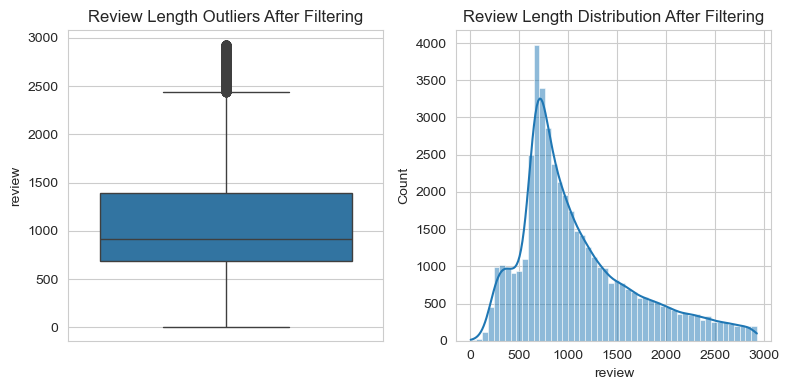

In [134]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(imdb_data_filtered['review'].apply(len), ax=axes[0])
axes[0].set_title("Review Length Outliers After Filtering")

sns.histplot(imdb_data_filtered['review'].apply(len), bins=50, kde=True, ax=axes[1])
axes[1].set_title("Review Length Distribution After Filtering")

plt.tight_layout()
plt.show()

- After removing outliers, reviews with extreme high lengths have been removed.
- Review length is less positively skewed.

In [102]:
imdb_data_filtered.describe()

,review,sentiment
count,45876,45876
unique,45876,2
top,One of the other reviewers has mentioned that ...,negative
freq,1,23029


- After removing outliers, 4124 records have been removed.

#### c. Reviews with extremely low review lengths

In [138]:
imdb_data_filtered[(imdb_data_filtered['review'].apply(len) < 30)]

,review,sentiment
26486,#ERROR!,negative


- The #ERROR! review can be removed as it is an error code rather than a review.

In [140]:
# Bad reviews removed
imdb_data_filtered = imdb_data_filtered[(imdb_data_filtered['review'].apply(len) > 30)]

#### d. Lowercase the text

In [145]:
imdb_data_filtered['processed_review'] = imdb_data_filtered['review'].apply(
    lambda x: x.lower()
)

#### e. Remove HTML tags

In [ ]:
imdb_data_filtered['processed_review'] = imdb_data_filtered['processed_review'].apply(
    lambda x: re.sub('<.*?>', '', x)
)

#### f. Remove punctutations and special characters

In [157]:
imdb_data_filtered['processed_review'] = imdb_data_filtered['processed_review'].apply(
    lambda x: re.sub(r'[^\w\s]', '', x)
)

#### g. Tokenize the test

In [164]:
imdb_data_filtered['processed_review'] = imdb_data_filtered['processed_review'].apply(
    lambda x: word_tokenize(x)
)

#### h. Remove stop words

In [184]:
stop_words = set(stopwords.words('english'))

imdb_data_filtered['processed_review'] = imdb_data_filtered['processed_review'].apply(
    lambda x: [word for word in x if word not in stop_words]
)

#### i. Lemmatize the tokens

In [186]:
lemmatizer = WordNetLemmatizer()

imdb_data_filtered['processed_review'] = imdb_data_filtered['processed_review'].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in x]
)

#### j. Remove numbers and words with 2 or less characters

In [195]:
# Remove the numbers and words, 2 characters or less
imdb_data_filtered['processed_review'] = imdb_data_filtered['processed_review'].apply(
    lambda x: [re.sub(r'\b\w{1,2}\b|\d+', '', word) for word in x]
)

# Get rid of empty strings
imdb_data_filtered['processed_review'] = imdb_data_filtered['processed_review'].apply(
    lambda x: [word for word in x if word != '']
)

#### k. Word cloud representation for positive and negative reviews

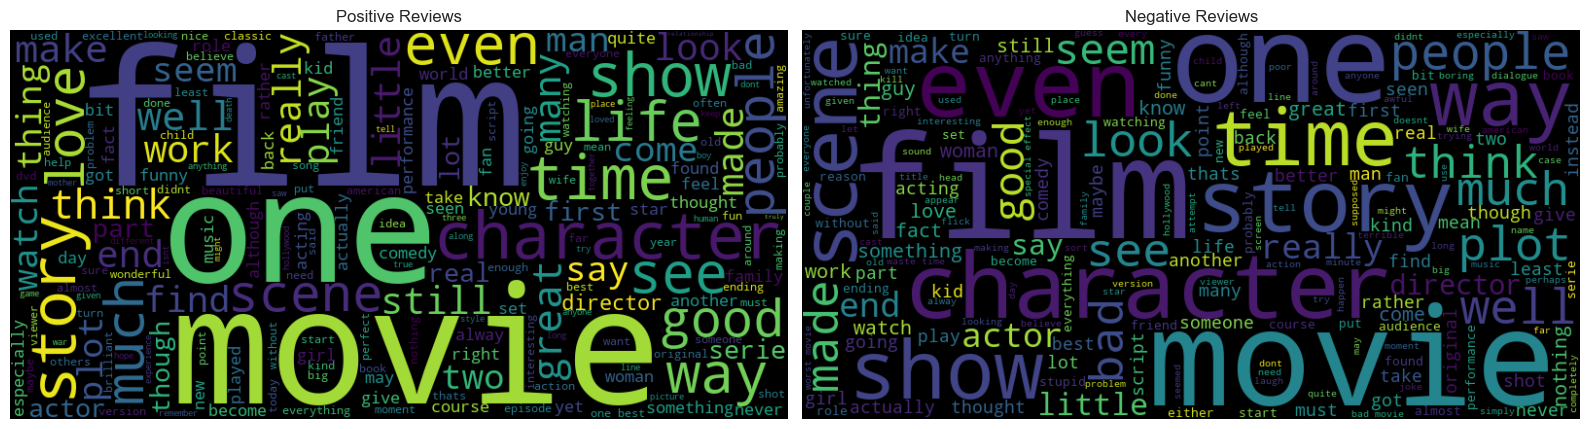

In [229]:
# Word frequency analysis
positive_reviews = imdb_data_filtered[imdb_data_filtered['sentiment'] == 'positive']['processed_review']
negative_reviews = imdb_data_filtered[imdb_data_filtered['sentiment'] == 'negative']['processed_review']

# Join all lists of words into a single string for positive reviews
text_pos = ' '.join([word for review in positive_reviews for word in review])

# Join all lists of words into a single string for negative reviews
text_neg = ' '.join([word for review in negative_reviews for word in review])

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Create a word cloud object for positive reviews
wordcloud_pos = WordCloud(width=800, height=400).generate(text_pos)

# Create a word cloud object for negative reviews
wordcloud_neg = WordCloud(width=800, height=400).generate(text_neg)

# Plot the word cloud for positive reviews on the first subplot
axs[0].imshow(wordcloud_pos, interpolation='bilinear')
axs[0].set_title('Positive Reviews')
axs[0].axis('off')

# Plot the word cloud for negative reviews on the second subplot
axs[1].imshow(wordcloud_neg, interpolation='bilinear')
axs[1].set_title('Negative Reviews')
axs[1].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

- Both positive and negative reviews have words like "movie", "film", "story", "one", etc.
- For positive reviews, words "love", "work", "life" is visible while they are not visible in the negative reviews.
- For negative reviews, words like "scene", "plot", "actor" is visible while they are not visible in positive reviews.

## 2. Feature Engineering

### a. Transform textual data into numbers for model use using TF-IDF

In [254]:
# Join words for vectorization
imdb_data_filtered['processed_text'] = imdb_data_filtered['processed_review'].apply(
    lambda x: ' '.join(x)
)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(imdb_data_filtered['processed_text'])

- It is not necessary to engineer features like word count, character count or average word length as TF-IDF captures a lot of rich information from text data.

## 3. Model Development and Evaluation

### a. Encode the categorical variable

In [267]:
for column in ['sentiment']:
    le = LabelEncoder()
    imdb_data_filtered[column] = le.fit_transform(imdb_data_filtered[column])

### b. Split data to train and test sets

In [277]:
# Prepare data
X = tfidf_features
y = imdb_data_filtered['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### c. Train Random Forest Classifier

In [287]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

#### c.1. Evaluate Random Forest Classifier

Accuracy: 0.848283378746594
Precision: 0.8420707732634338
Recall: 0.8521220159151194
F1 Score: 0.8470665787738958
ROC-AUC: 0.8483357875748463


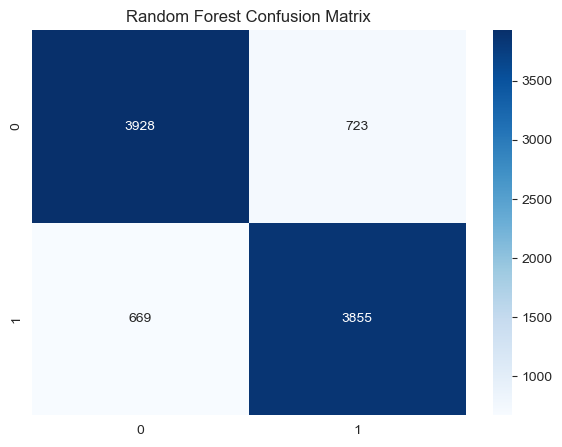

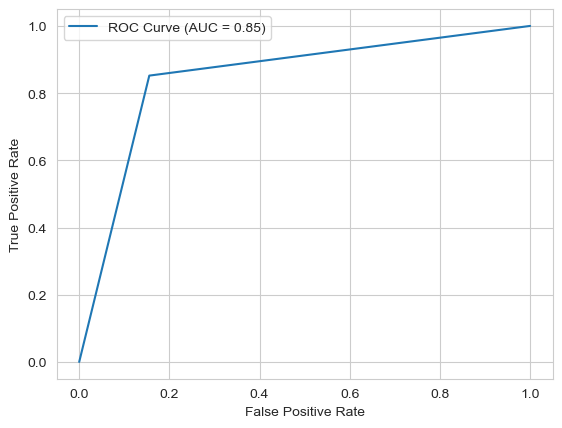

In [293]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### d. Train Support Vector Classifier

In [301]:
# Create and train model
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

#### d.1. Evaluate Support Vector Classifier

Accuracy: 0.8934059945504087
Precision: 0.8780383795309168
Recall: 0.9102564102564102
F1 Score: 0.8938571738658563
ROC-AUC: 0.8936360529028772


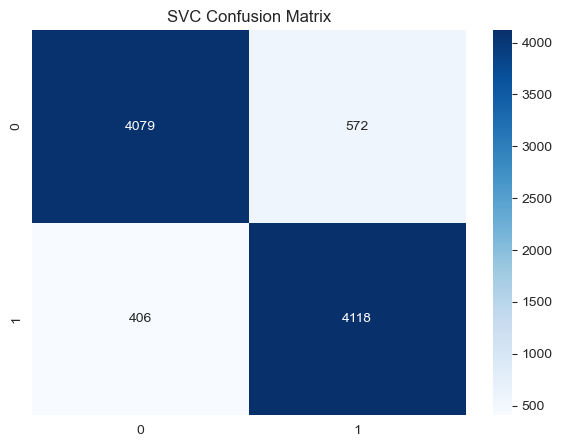

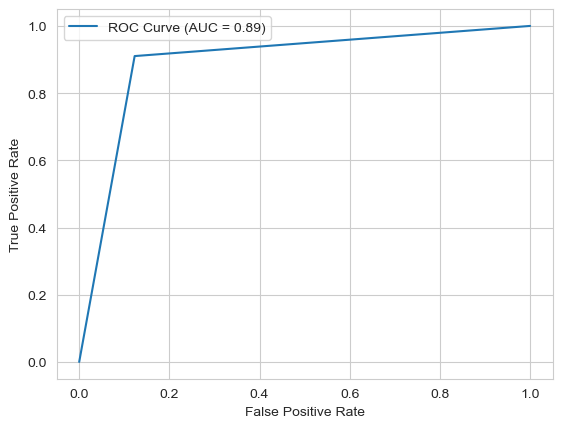

In [304]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("SVC Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### e. Train Logistic Regression

In [319]:
# Train logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
# Predict labels on the test set
y_pred = lr.predict(X_test)

#### e.1. Evaluate Logistic Regression

Accuracy: 0.8900272479564033
Precision: 0.8746535919846514
Recall: 0.9069407603890363
F1 Score: 0.8905046120455778
ROC-AUC: 0.8902581677670832


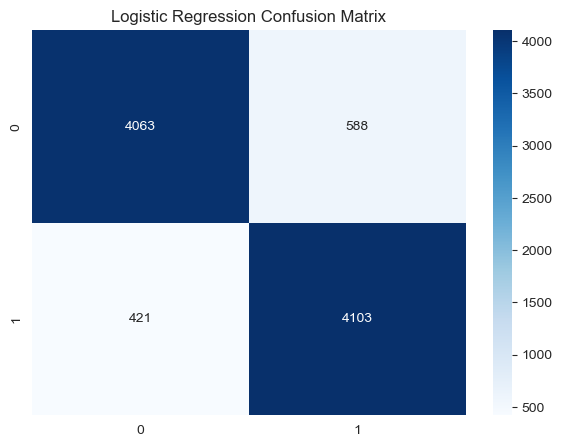

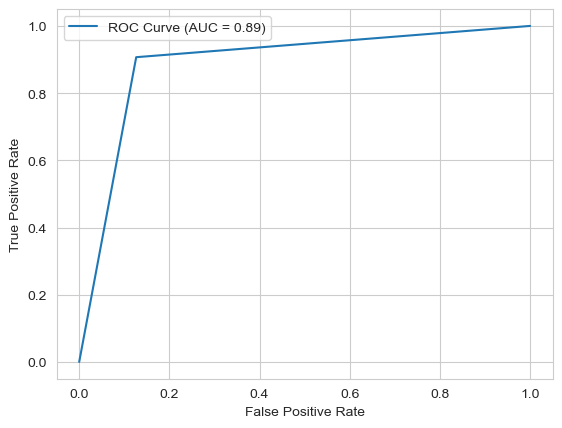

In [321]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### f. Train Naive Bayes Classifier

In [331]:
# Train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

#### f.1. Evaluate Naive Bayes

Accuracy: 0.8638692098092643
Precision: 0.879138689511461
Recall: 0.8393015030946065
F1 Score: 0.858758339929888
ROC-AUC: 0.86353378745356


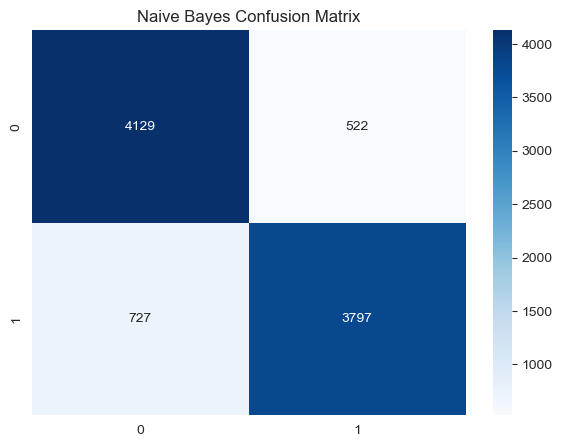

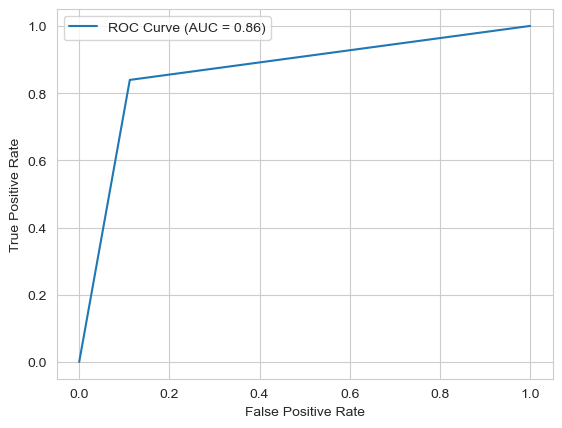

In [333]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## 4. Model Evaluation

- Support Vector Machine is the most optimal model with f1-score 0.893.
- ROC-AUC of 0.893 means the model has high discriminatory power.
- False positives: 572, False negatives: 406, which is slightly better that logistic regression.
- Of all reviews predicted as positive, 87.8% were actually positive.
- Of all actual positive reviews, 91% were correctly identified.

# Part B: News Article Classification

## Video Presentation: [Click here](https://drive.google.com/file/d/1rZ5yQgPggodkhZzjGuz6R7Kjjs7hgTaJ/view?usp=drive_link)

In [340]:
news_data = pd.read_csv("data_news.csv")
news_data.head(3)

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug


## 1. Data Collection and Preprocessing

### a. Missing data

In [343]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


- 50,000 rows with 2668 values missing in keywords column.

### b. Unique news

In [347]:
news_data.describe()

,category,headline,links,short_description,keywords
count,50000,50000,50000,50000,47332
unique,10,45577,45745,45743,41558
top,WELLNESS,Sunday Roundup,https://www.huffingtonpost.com/entry/bryce-har...,"Along with his fists, the star Nationals outfi...",post
freq,5000,22,8,8,85


- Can avoid links column.
- There are 10 unique categories.
- There are 45577 unique headlines and 45743 unique short descriptions. If a short description is repeated, it is highly likely a repeat entry.
- Keywords can be repeated because different articles can have same keywords.

### c. Category distribution

In [352]:
news_data["category"].value_counts()

category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64

- All the categories are equally distributed with 5000 each.

### d. Remove the link column

- Since the link does not contribute to finding categories.

In [404]:
required_data = news_data.drop('links', axis=1)

### e. Check headline, description and keyword length

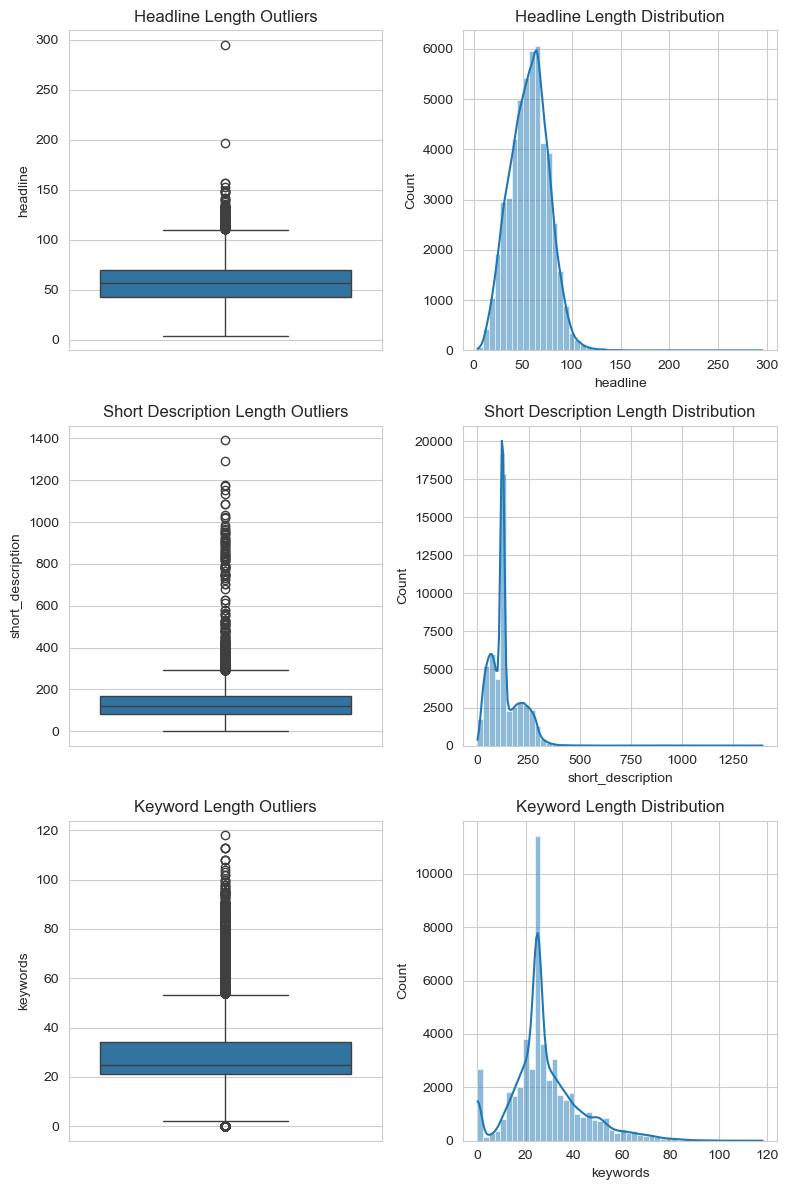

In [377]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(8, 12))

sns.boxplot(required_data['headline'].apply(len), ax=axes[0,0])
axes[0,0].set_title("Headline Length Outliers")

sns.histplot(required_data['headline'].apply(len), bins=50, kde=True, ax=axes[0,1])
axes[0,1].set_title("Headline Length Distribution")

sns.boxplot(required_data['short_description'].apply(len), ax=axes[1,0])
axes[1,0].set_title("Short Description Length Outliers")

sns.histplot(required_data['short_description'].apply(len), bins=50, kde=True, ax=axes[1,1])
axes[1,1].set_title("Short Description Length Distribution")

keyword_length = required_data['keywords'].fillna('').apply(len)

sns.boxplot(keyword_length, ax=axes[2,0])
axes[2,0].set_title("Keyword Length Outliers")

sns.histplot(keyword_length, bins=50, kde=True, ax=axes[2,1])
axes[2,1].set_title("Keyword Length Distribution")

plt.tight_layout()
plt.show()

- Many outliers in headline, short descriptions and keywords.
- Headline distribution looks balanced.
- Short description is extremely uneven.
- Keywords look normally distributed with a positive skew.

### f. Keep only data with unique short descriptions

In [410]:
required_data = required_data.drop_duplicates(subset='short_description', keep='first')
required_data.describe()

,category,headline,short_description
count,45743,45743,45743
unique,10,45571,45743
top,WELLNESS,Sunday Roundup,Resting is part of training. I've confirmed wh...
freq,5000,22,1


- After keeping only unique short descriptions, 4257 rows were removed

### g. Audit repeated headlines

- Headlines can be same but description is different, eg: Sunday Roundup.
- Keywords and headline is similar, cleaning and tokenization will make them similar, therefore, it is better to remove the keywords 

In [388]:
required_data[required_data['headline'].duplicated()]

,category,headline,short_description,keywords
3753,WELLNESS,The Moment I Knew,It's the illogical shame you feel when you tak...,the-moment-i-knew
4257,WELLNESS,Never Too Late,The next time you think about grabbing a bag o...,weight-loss-success
5324,POLITICS,Sunday Roundup,Happy 4th of July weekend! The week leading up...,sunday-roundup
5843,POLITICS,Sunday Roundup,This week proved that while the arc of the mor...,sunday-roundup
5932,POLITICS,Sunday Roundup,"This week, the House voted along party lines t...",sunday-roundup
...,...,...,...,...
39549,WORLD NEWS,North Korea Fires Submarine-Launched Missile: ...,North Korea has been testing its weapons syste...,north-korea-submarine-missile
39863,WORLD NEWS,The Crossing,An immersive reporting series hosted by Susan ...,NaN
41420,BUSINESS,Redefining Success,Success is your net-worth. Your net-worth not ...,redefining-success
42075,BUSINESS,10 Ways To Spot A Truly Exceptional Employee,Dealing with difficult people is frustrating a...,10-ways-to-spot-a-truly-e


### h. Removing keywords column

In [406]:
required_data = required_data.drop('keywords', axis=1)

### i. Remove short description and headline length outliers

In [420]:
# Calculate Q1 and Q3
Q1 = required_data['short_description'].apply(len).quantile(0.25)
Q3 = required_data['short_description'].apply(len).quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
required_data = required_data[(required_data['short_description'].apply(len) >= lower_bound) & 
                                 (required_data['short_description'].apply(len) <= upper_bound)
]

In [425]:
# Calculate Q1 and Q3
Q1 = required_data['headline'].apply(len).quantile(0.25)
Q3 = required_data['headline'].apply(len).quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
required_data = required_data[(required_data['headline'].apply(len) >= lower_bound) & 
                                 (required_data['headline'].apply(len) <= upper_bound)
]

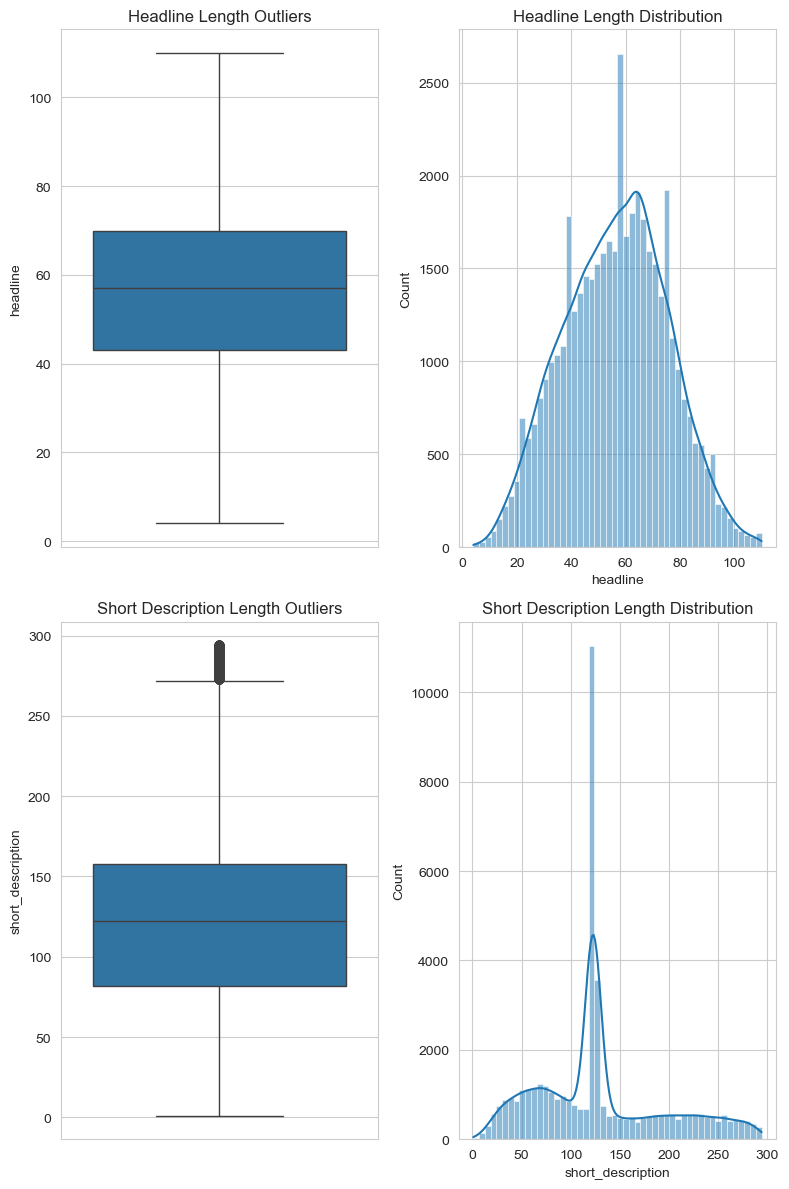

In [427]:
fig, axes = plt.subplots(2, 2, figsize=(8, 12))

sns.boxplot(required_data['headline'].apply(len), ax=axes[0,0])
axes[0,0].set_title("Headline Length Outliers")

sns.histplot(required_data['headline'].apply(len), bins=50, kde=True, ax=axes[0,1])
axes[0,1].set_title("Headline Length Distribution")

sns.boxplot(required_data['short_description'].apply(len), ax=axes[1,0])
axes[1,0].set_title("Short Description Length Outliers")

sns.histplot(required_data['short_description'].apply(len), bins=50, kde=True, ax=axes[1,1])
axes[1,1].set_title("Short Description Length Distribution")

plt.tight_layout()
plt.show()

- Short description has most character lengths between 120 and 130.

In [469]:
required_data.describe()

,category,headline,short_description
count,44429,44429,44429
unique,10,44279,44429
top,FOOD & DRINK,Weekly Roundup of eBay Vintage Clothing Finds ...,Resting is part of training. I've confirmed wh...
freq,4973,17,1


- After cleanup, 5571 rows are removed

In [474]:
required_data["category"].value_counts()

category
FOOD & DRINK      4973
STYLE & BEAUTY    4939
ENTERTAINMENT     4899
WELLNESS          4862
PARENTING         4836
TRAVEL            4798
POLITICS          4782
WORLD NEWS        4769
BUSINESS          2948
SPORTS            2623
Name: count, dtype: int64

- The balance of categories is affected. Business and Sports articles are poorly represented compared to others.

### j. Concatenate headline and description for preprocessing

In [522]:
article_cleaned_data = pd.DataFrame({
    'combined_text': required_data['headline'] + ' ' + required_data['short_description'],
    'category': required_data['category']
})

### k. Lowercase the text

In [545]:
article_cleaned_data['processed_text'] = article_cleaned_data['combined_text'].apply(
    lambda x: x.lower()
)

### l. Remove HTML tags

In [550]:
article_cleaned_data['processed_text'] = article_cleaned_data['processed_text'].apply(
    lambda x: re.sub('<.*?>', '', x)
)

### m. Remove punctuations and special characters

In [555]:
article_cleaned_data['processed_text'] = article_cleaned_data['processed_text'].apply(
    lambda x: re.sub(r'[^\w\s]', '', x)
)

### n. Tokenize the text

In [560]:
article_cleaned_data['processed_text'] = article_cleaned_data['processed_text'].apply(
    lambda x: word_tokenize(x)
)

### o. Remove stop words

In [565]:
article_cleaned_data['processed_text'] = article_cleaned_data['processed_text'].apply(
    lambda x: [word for word in x if word not in stop_words]
)

### p. Lemmatize the tokens

In [570]:
article_cleaned_data['processed_text'] = article_cleaned_data['processed_text'].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in x]
)

### q. Remove numbers and words having 2 characters or less

In [575]:
# Remove the numbers and words, 2 characters or less
article_cleaned_data['processed_text'] = article_cleaned_data['processed_text'].apply(
    lambda x: [re.sub(r'\b\w{1,2}\b|\d+', '', word) for word in x]
)

# Get rid of empty strings
article_cleaned_data['processed_text'] = article_cleaned_data['processed_text'].apply(
    lambda x: [word for word in x if word != '']
)

## 2. Feature Extraction

### a. Distribution of different categories

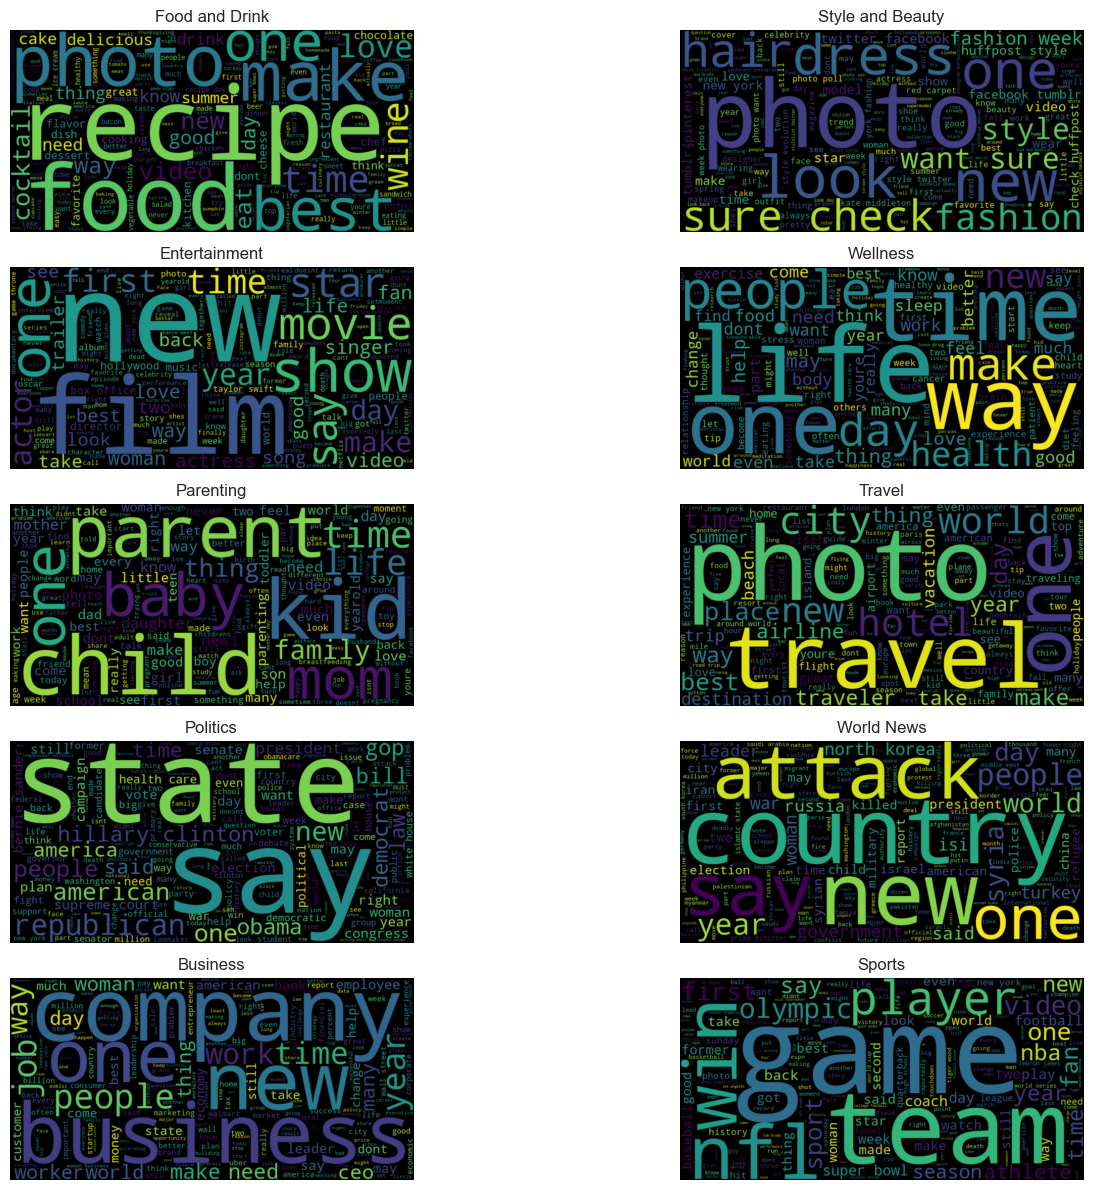

In [589]:
# Word frequency analysis
food_drink = article_cleaned_data[article_cleaned_data['category'] == 'FOOD & DRINK']['processed_text']
style_beauty = article_cleaned_data[article_cleaned_data['category'] == 'STYLE & BEAUTY']['processed_text']
entertainment = article_cleaned_data[article_cleaned_data['category'] == 'ENTERTAINMENT']['processed_text']
wellness = article_cleaned_data[article_cleaned_data['category'] == 'WELLNESS']['processed_text']
parenting = article_cleaned_data[article_cleaned_data['category'] == 'PARENTING']['processed_text']
travel = article_cleaned_data[article_cleaned_data['category'] == 'TRAVEL']['processed_text']
politics = article_cleaned_data[article_cleaned_data['category'] == 'POLITICS']['processed_text']
world_news = article_cleaned_data[article_cleaned_data['category'] == 'WORLD NEWS']['processed_text']
business = article_cleaned_data[article_cleaned_data['category'] == 'BUSINESS']['processed_text']
sports = article_cleaned_data[article_cleaned_data['category'] == 'SPORTS']['processed_text']

# Join all lists of words into a single string
text_food_drink = ' '.join([word for review in food_drink for word in review])
text_style_beauty = ' '.join([word for review in style_beauty for word in review])
text_ent = ' '.join([word for review in entertainment for word in review])
text_well = ' '.join([word for review in wellness for word in review])
text_parent = ' '.join([word for review in parenting for word in review])
text_travel = ' '.join([word for review in travel for word in review])
text_polit = ' '.join([word for review in politics for word in review])
text_world = ' '.join([word for review in world_news for word in review])
text_business = ' '.join([word for review in business for word in review])
text_sports = ' '.join([word for review in sports for word in review])

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(16, 12))

# Create a word cloud object
wordcloud_food_drink = WordCloud(width=800, height=400).generate(text_food_drink)
wordcloud_style_beauty = WordCloud(width=800, height=400).generate(text_style_beauty)
wordcloud_ent = WordCloud(width=800, height=400).generate(text_ent)
wordcloud_well = WordCloud(width=800, height=400).generate(text_well)
wordcloud_parent = WordCloud(width=800, height=400).generate(text_parent)
wordcloud_travel = WordCloud(width=800, height=400).generate(text_travel)
wordcloud_polit = WordCloud(width=800, height=400).generate(text_polit)
wordcloud_world = WordCloud(width=800, height=400).generate(text_world)
wordcloud_business = WordCloud(width=800, height=400).generate(text_business)
wordcloud_sports = WordCloud(width=800, height=400).generate(text_sports)

# Plot the word cloud for positive reviews on the first subplot
axs[0,0].imshow(wordcloud_food_drink, interpolation='bilinear')
axs[0,0].set_title('Food and Drink')
axs[0,0].axis('off')

# Plot the word cloud for negative reviews on the second subplot
axs[0,1].imshow(wordcloud_style_beauty, interpolation='bilinear')
axs[0,1].set_title('Style and Beauty')
axs[0,1].axis('off')

# Plot the word cloud for positive reviews on the first subplot
axs[1,0].imshow(wordcloud_ent, interpolation='bilinear')
axs[1,0].set_title('Entertainment')
axs[1,0].axis('off')

# Plot the word cloud for negative reviews on the second subplot
axs[1,1].imshow(wordcloud_well, interpolation='bilinear')
axs[1,1].set_title('Wellness')
axs[1,1].axis('off')

# Plot the word cloud for positive reviews on the first subplot
axs[2,0].imshow(wordcloud_parent, interpolation='bilinear')
axs[2,0].set_title('Parenting')
axs[2,0].axis('off')

# Plot the word cloud for negative reviews on the second subplot
axs[2,1].imshow(wordcloud_travel, interpolation='bilinear')
axs[2,1].set_title('Travel')
axs[2,1].axis('off')

# Plot the word cloud for positive reviews on the first subplot
axs[3,0].imshow(wordcloud_polit, interpolation='bilinear')
axs[3,0].set_title('Politics')
axs[3,0].axis('off')

# Plot the word cloud for negative reviews on the second subplot
axs[3,1].imshow(wordcloud_world, interpolation='bilinear')
axs[3,1].set_title('World News')
axs[3,1].axis('off')

# Plot the word cloud for positive reviews on the first subplot
axs[4,0].imshow(wordcloud_business, interpolation='bilinear')
axs[4,0].set_title('Business')
axs[4,0].axis('off')

# Plot the word cloud for negative reviews on the second subplot
axs[4,1].imshow(wordcloud_sports, interpolation='bilinear')
axs[4,1].set_title('Sports')
axs[4,1].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

- Food and drink have words like recipe, make, etc.
- Style and Beauty have words like photo, dress, fashion, etc.
- Entertainment have words like film, show, movie, etc.
- Wellmess have words like life, people, way, etc.
- Parenting have words like child, parent, kid, etc.
- Travel have words like photo, travel, hotel, etc.
- Politics have words like state, say, bill, etc.
- World news have words like attack, country, new, etc.
- Business have words like company, business, job, etc.
- Sports have words like game, team, win etc.

### b. Convert text data to numbers using TF-IDF for model use

In [595]:
# Join words for vectorization
article_cleaned_data['processed_tokens'] = article_cleaned_data['processed_text'].apply(
    lambda x: ' '.join(x)
)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(article_cleaned_data['processed_tokens'])

## 3. Model Development and Training

### a. Encode categorical variable

In [605]:
for column in ['category']:
    le = LabelEncoder()
    article_cleaned_data[column] = le.fit_transform(article_cleaned_data[column])

### b. Split to train and test set

In [610]:
# Prepare data
X = tfidf_features
y = article_cleaned_data['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### c. Train Logistic Regression

In [615]:
# Train logistic regression model
lr_news = LogisticRegression(random_state=42)
lr_news.fit(X_train, y_train)
# Predict labels on the test set
y_pred = lr_news.predict(X_test)

#### c1. Evaluate Logistic regression

Accuracy: 0.7970965563808238
Precision: 0.7990204823674877
Recall: 0.7970965563808238
F1 Score: 0.796620355919033
ROC-AUC: 0.86353378745356


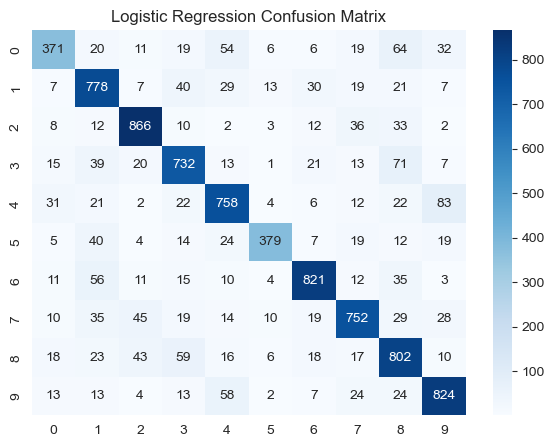

In [628]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

### d. Train Naive Bayes

In [631]:
# Train the Naive Bayes classifier
nb_news_model = MultinomialNB()
nb_news_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_news_model.predict(X_test)

#### d.1. Evaluate Naive Bayes

Accuracy: 0.7587215845149674
Precision: 0.778732082301321
Recall: 0.7587215845149674
F1 Score: 0.749211640617267
ROC-AUC: 0.86353378745356


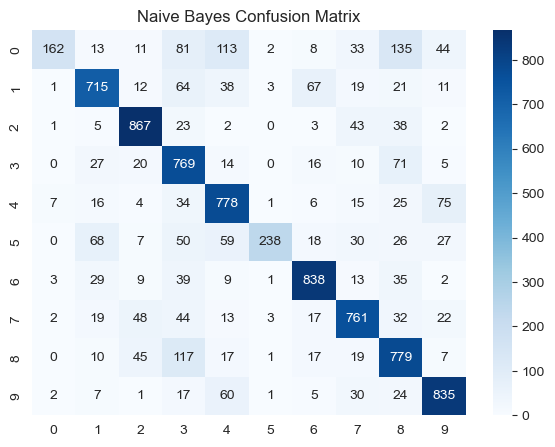

In [634]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.show()

### e. Train SVM

In [637]:
# Create and train model
svm_news = SVC(random_state=42)
svm_news.fit(X_train, y_train)

# Make predictions
y_pred = svm_news.predict(X_test)

#### e.1. Evaluate SVM

Accuracy: 0.795295971190637
Precision: 0.7993565057439405
Recall: 0.795295971190637
F1 Score: 0.7953872693835766
ROC-AUC: 0.86353378745356


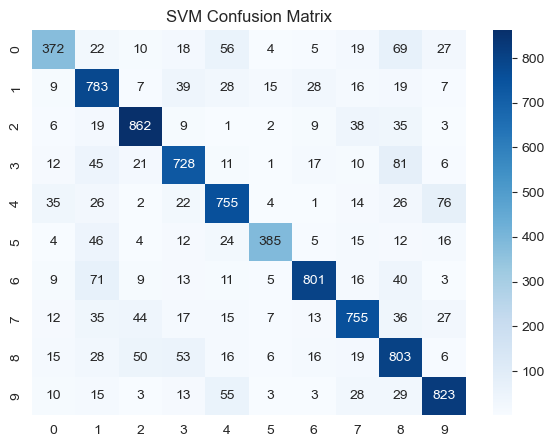

In [640]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

### f. Randomized search for hyper parameter tuning

- Performed tuning on logistic regression since it performed slightly better than SVM

In [658]:
# Logistic Regression model
logreg = LogisticRegression(random_state=42)

# Hyperparameter space
param_distributions = {
    'C': uniform(loc=0.01, scale=10),  # Range of C (e.g., from 0.01 to 10)
    'penalty': ['l2'],         # Regularization types
    'solver': ['liblinear'],  # Solvers supported for given penalties
}

# Random search setup
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='f1_weighted',  # Metric to optimize
    random_state=42,
    verbose=1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best parameters and performance
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best F1 Score: {random_search.best_score_:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': 3.7554011884736247, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Score: 0.80


### g. Best Model

Accuracy: 0.8032860679720909
Precision: 0.8039221796184353
Recall: 0.8032860679720909
F1 Score: 0.8029854405956157
ROC-AUC: 0.86353378745356


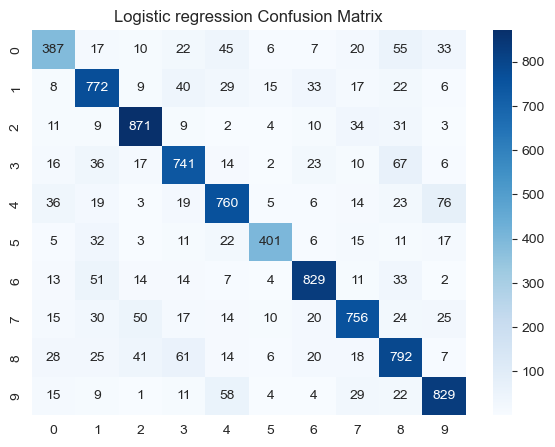

In [660]:
# Use best estimator for predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic regression Confusion Matrix")
plt.show()

## 4. Model Evaluation

- The best model is logistic regression model with f1 score: 0.802
- Precision and Recall are balanced at 0.803
- Accuracy is also at 0.80
- Naive bayes is the worst with 0.74 f1 score.
- SVM is slightly poor with 0.795 f1 score and takes a long time to train.